# ScBasset: Analyzing scATACseq data

Note: code are mostly from

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scbasset.html

https://github.com/calico/scBasset

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
!pip install muon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 KB 6.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns

In [ ]:
scvi.settings.seed = 0

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

INFO:lightning_fabric.utilities.seed:Global seed set to 0


## Loading data and preprocessing

Throughout this tutorial, we use [sample multiome data from 10X of 10K PBMCs](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0).

In [ ]:
url="https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5"
#url = "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/10k_PBMC_Multiome_nextgem_Chromium_X/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"
mdata = muon.read_10x_h5('data/multiome10k.h5mu',backup_url = url)

  0%|          | 0.00/37.0M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/multiome10k.h5mu


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.9/dist-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [ ]:
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2711 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	2711 x 98319
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'chr', 'start', 'end'

In [ ]:
adata = mdata.mod["atac"]

In [ ]:
import pickle

In [ ]:
with open('adata.pickle', 'wb') as f:
    pickle.dump(adata, f)

We can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [ ]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(2711, 98319)
(2711, 30957)


In [ ]:
print(adata.obs)

Empty DataFrame
Columns: []
Index: [AAACAGCCAAATATCC-1, AAACAGCCAGGAACTG-1, AAACAGCCAGGCTTCG-1, AAACCAACACCTGCTC-1, AAACCAACAGATTCAT-1, AAACCAACAGTTGCGT-1, AAACCAACATAACGGG-1, AAACCAACATAGACCC-1, AAACCGCGTGAGGTAG-1, AAACGCGCATACCCGG-1, AAACGGATCCTAGTAA-1, AAACGTACAAATACCT-1, AAAGCACCACCCACCT-1, AAAGCTTGTGTGTGGT-1, AAAGGACGTATTGTGG-1, AAAGGACGTCATCCTG-1, AAAGGACGTTAAGCCA-1, AAAGGACGTTCACCAT-1, AAAGGAGCACAAACTT-1, AAAGGAGCATAGCTGC-1, AAAGGCTCACCGTTCC-1, AAAGGCTCACTTCACT-1, AAAGGTTAGCAAGGGT-1, AAAGGTTAGGGTGGAT-1, AAATCCGGTTAGCGTA-1, AAATGCCTCCAGGAAA-1, AAATGCCTCGCTAAAC-1, AACAAAGGTAATGGAA-1, AACAAGCCAGGTTCAC-1, AACAGATAGAGGCTAA-1, AACAGATAGGGTCCAC-1, AACAGCAAGGAAGCTA-1, AACAGGATCACTAGGT-1, AACAGGATCATCACTT-1, AACAGGATCTACCTGC-1, AACATAGCATAAAGCA-1, AACATCATCCGTTATT-1, AACATCATCGAGGAAC-1, AACATCATCGGCTATG-1, AACCCGCAGTAACAGG-1, AACCCGCAGTCACTAA-1, AACCGGCTCCGTAAAC-1, AACCGGCTCGATCAGT-1, AACCGGCTCGTTAGCG-1, AACCTCCTCCCTCACG-1, AACCTTAAGGTCTTGG-1, AACCTTGCAATAATCC-1, AACCTTGCAGCCTGCA-1, AACC

In [ ]:
print(adata.X[:10,:10])
print(adata.X.shape)

  (0, 4)	2.0
  (1, 8)	4.0
  (2, 2)	2.0
  (3, 2)	4.0
  (3, 6)	1.0
  (3, 8)	4.0
  (4, 2)	3.0
  (4, 7)	2.0
  (5, 9)	2.0
  (6, 8)	2.0
  (7, 2)	3.0
  (8, 2)	2.0
  (8, 4)	2.0
(2711, 30957)


In [ ]:
adata.var

,gene_ids,feature_types,genome,interval,chr,start,end,n_cells
chr1:629484-630393,chr1:629484-630393,Peaks,GRCh38,chr1:629484-630393,chr1,629484,630393,154
chr1:633556-634476,chr1:633556-634476,Peaks,GRCh38,chr1:633556-634476,chr1,633556,634476,428
chr1:778284-779202,chr1:778284-779202,Peaks,GRCh38,chr1:778284-779202,chr1,778284,779202,1317
chr1:816877-817780,chr1:816877-817780,Peaks,GRCh38,chr1:816877-817780,chr1,816877,817780,163
chr1:827063-827952,chr1:827063-827952,Peaks,GRCh38,chr1:827063-827952,chr1,827063,827952,616
...,...,...,...,...,...,...,...,...
GL000195.1:32192-33044,GL000195.1:32192-33044,Peaks,GRCh38,GL000195.1:32192-33044,GL000195.1,32192,33044,328
GL000219.1:39937-40840,GL000219.1:39937-40840,Peaks,GRCh38,GL000219.1:39937-40840,GL000219.1,39937,40840,265
GL000219.1:42161-43054,GL000219.1:42161-43054,Peaks,GRCh38,GL000219.1:42161-43054,GL000219.1,42161,43054,651
GL000219.1:99257-100164,GL000219.1:99257-100164,Peaks,GRCh38,GL000219.1:99257-100164,GL000219.1,99257,100164,1535


In [ ]:
split_interval = adata.var["gene_ids"].str.split(":", expand=True)
adata.var["chr"] = split_interval[0]
split_start_end = split_interval[1].str.split("-", expand=True)
adata.var["start"] = split_start_end[0].astype(int)
adata.var["end"] = split_start_end[1].astype(int)
adata.var

,gene_ids,feature_types,genome,interval,n_cells,chr,start,end
chr1:629484-630393,chr1:629484-630393,Peaks,GRCh38,chr1:629484-630393,154,chr1,629484,630393
chr1:633556-634476,chr1:633556-634476,Peaks,GRCh38,chr1:633556-634476,428,chr1,633556,634476
chr1:778284-779202,chr1:778284-779202,Peaks,GRCh38,chr1:778284-779202,1317,chr1,778284,779202
chr1:816877-817780,chr1:816877-817780,Peaks,GRCh38,chr1:816877-817780,163,chr1,816877,817780
chr1:827063-827952,chr1:827063-827952,Peaks,GRCh38,chr1:827063-827952,616,chr1,827063,827952
...,...,...,...,...,...,...,...,...
GL000195.1:32192-33044,GL000195.1:32192-33044,Peaks,GRCh38,GL000195.1:32192-33044,328,GL000195.1,32192,33044
GL000219.1:39937-40840,GL000219.1:39937-40840,Peaks,GRCh38,GL000219.1:39937-40840,265,GL000219.1,39937,40840
GL000219.1:42161-43054,GL000219.1:42161-43054,Peaks,GRCh38,GL000219.1:42161-43054,651,GL000219.1,42161,43054
GL000219.1:99257-100164,GL000219.1:99257-100164,Peaks,GRCh38,GL000219.1:99257-100164,1535,GL000219.1,99257,100164


In [ ]:
# Filter out non-chromosomal regions
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [ ]:
scvi.data.add_dna_sequence(
    adata,
    genome_name="GRCh38",
    genome_dir="data",
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
)
adata

23:09:55 | INFO | Downloading assembly summaries from GENCODE
23:10:14 | INFO | Downloading assembly summaries from UCSC
23:10:17 | INFO | Downloading genome from GENCODE. Target URL: http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...


Download:   0%|          | 0.00/938M [00:00<?, ?B/s]

23:10:45 | INFO | Genome download successful, starting post processing...
23:11:19 | INFO | name: hg38
23:11:19 | INFO | local name: GRCh38
23:11:19 | INFO | fasta: /content/data/GRCh38/GRCh38.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

Working...: 100%|██████████| 23/23 [00:05<00:00,  3.96it/s]


AnnData object with n_obs × n_vars = 2711 × 30949
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'chr', 'start', 'end'
    varm: 'dna_sequence', 'dna_code'

In [ ]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333
chr1:629484-630393,T,C,T,G,A,C,C,T,C,C,...,A,C,A,C,A,A,A,A,C,C
chr1:633556-634476,A,A,A,T,C,T,G,T,G,G,...,G,C,C,T,T,T,T,A,C,C
chr1:778284-779202,C,T,A,A,T,T,T,T,T,G,...,G,A,G,G,A,C,A,G,G,A
chr1:816877-817780,G,G,A,A,T,G,A,A,A,A,...,T,T,T,A,G,C,G,G,C,T
chr1:827063-827952,C,C,T,G,C,C,C,C,A,C,...,T,T,A,C,T,T,C,G,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155188576-155189458,T,T,T,C,A,T,A,A,T,G,...,A,A,G,T,T,C,T,G,G,G
chrX:155215980-155216846,T,G,G,T,T,C,T,G,T,A,...,C,C,G,A,T,G,G,G,A,A
chrX:155263994-155264867,G,T,A,A,C,A,T,A,G,G,...,A,T,T,T,A,A,C,A,G,T
chrX:155612294-155613227,G,T,T,T,A,A,T,A,G,T,...,A,T,A,C,A,T,A,T,T,A


## Creating and training the model

We can now set up the AnnData object, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [ ]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


We can now create a scBasset model object and train it!

<div class="alert alert-info">
Note

The default max epochs is set to 1000, but in practice scBasset stops early once the model converges, which rarely requires that many, especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data).

</div>

Here we are using 16 bit precision which uses less memory without sacrificing performance.

In [ ]:
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:751: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
bas.save("saved_models", overwrite=False, save_anndata=False)

In [ ]:
path = "bastrain.pt"
bas.save(path, prefix=None, overwrite=False, save_anndata=False)

Import the trained model, no need to train again.

In [ ]:
# Load the saved SCBASSET model
bas = scvi.external.SCBASSET.load("/content", adata=bdata)

INFO     File /content/model.pt already downloaded                                                                 


Save bdata

In [ ]:
import pickle

with open("bdata.pk", "wb") as f:
    # use pickle to dump the variable to the file
    pickle.dump(bdata, f)

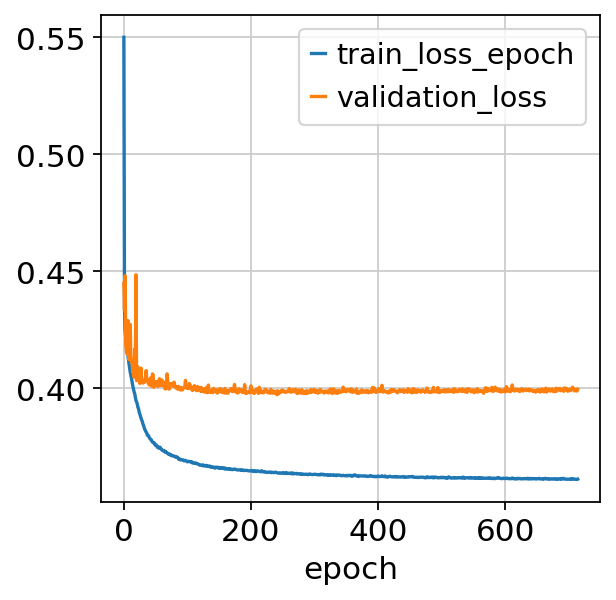

In [ ]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)
fig.savefig('loss.png')

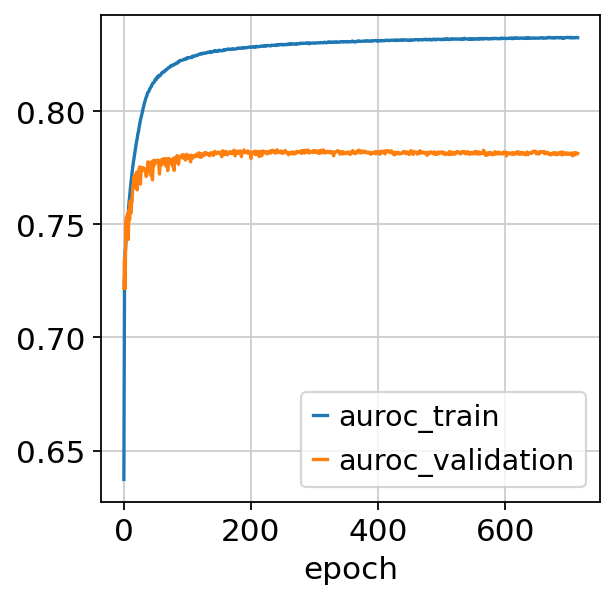

In [ ]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)
fig.savefig('auroc.png')

## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [ ]:
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

print(latent.shape)

(2711, 32)


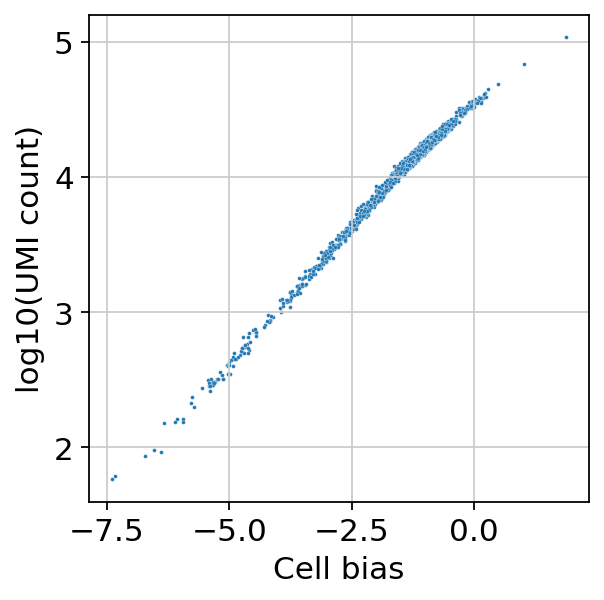

In [ ]:
sns.scatterplot(
    x=bas.get_cell_bias(),
    y=np.log10(np.asarray(adata.X.sum(1))).ravel(),
    s=3,
)
plt.xlabel("Cell bias")
plt.ylabel("log10(UMI count)")
plt.savefig('count_bias.png')

We can now use scanpy functions to cluster and visualize our latent space:

In [ ]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_scbasset")
# compute the umap
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scbasset")

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


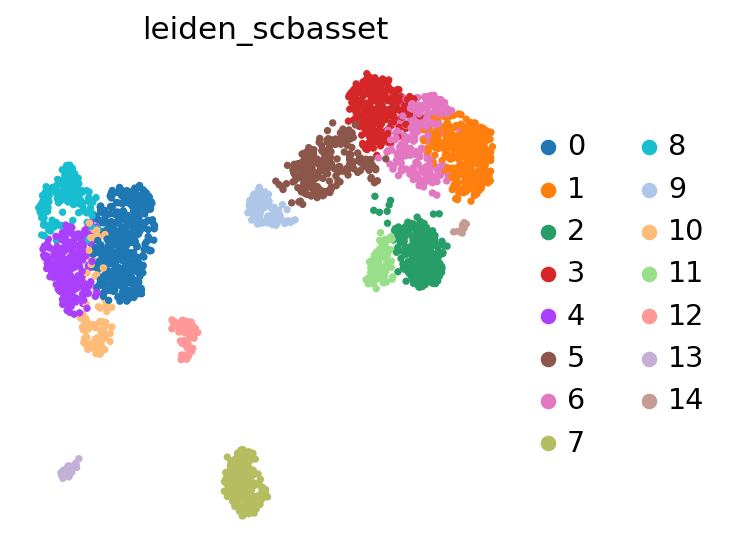

In [ ]:
sc.pl.umap(adata, color="leiden_scbasset",save='_umap.png')


## Cell annotation

rna gene expression dataset

In [ ]:
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2711 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	2711 x 98319
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [ ]:
cdata = mdata.mod['rna']

In [ ]:
import pickle
with open('cdata.pickle', 'wb') as f:
    pickle.dump(cdata, f)

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [ ]:
cdata.var_names_make_unique() 

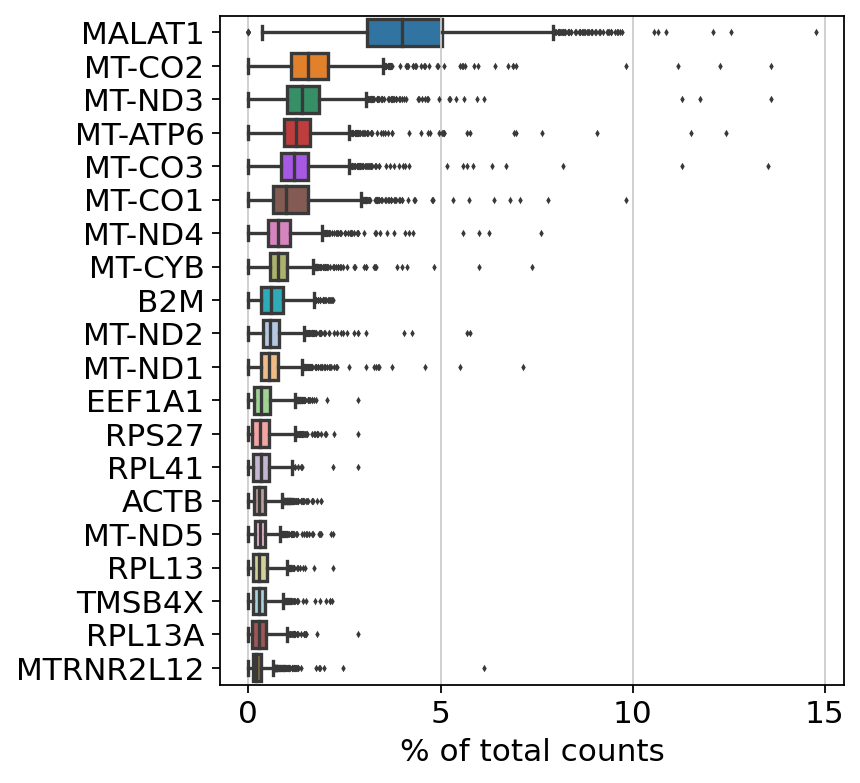

In [ ]:
sc.pl.highest_expr_genes(cdata, n_top=20, )

filtering

In [ ]:
cdata.var['mt'] = cdata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(cdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

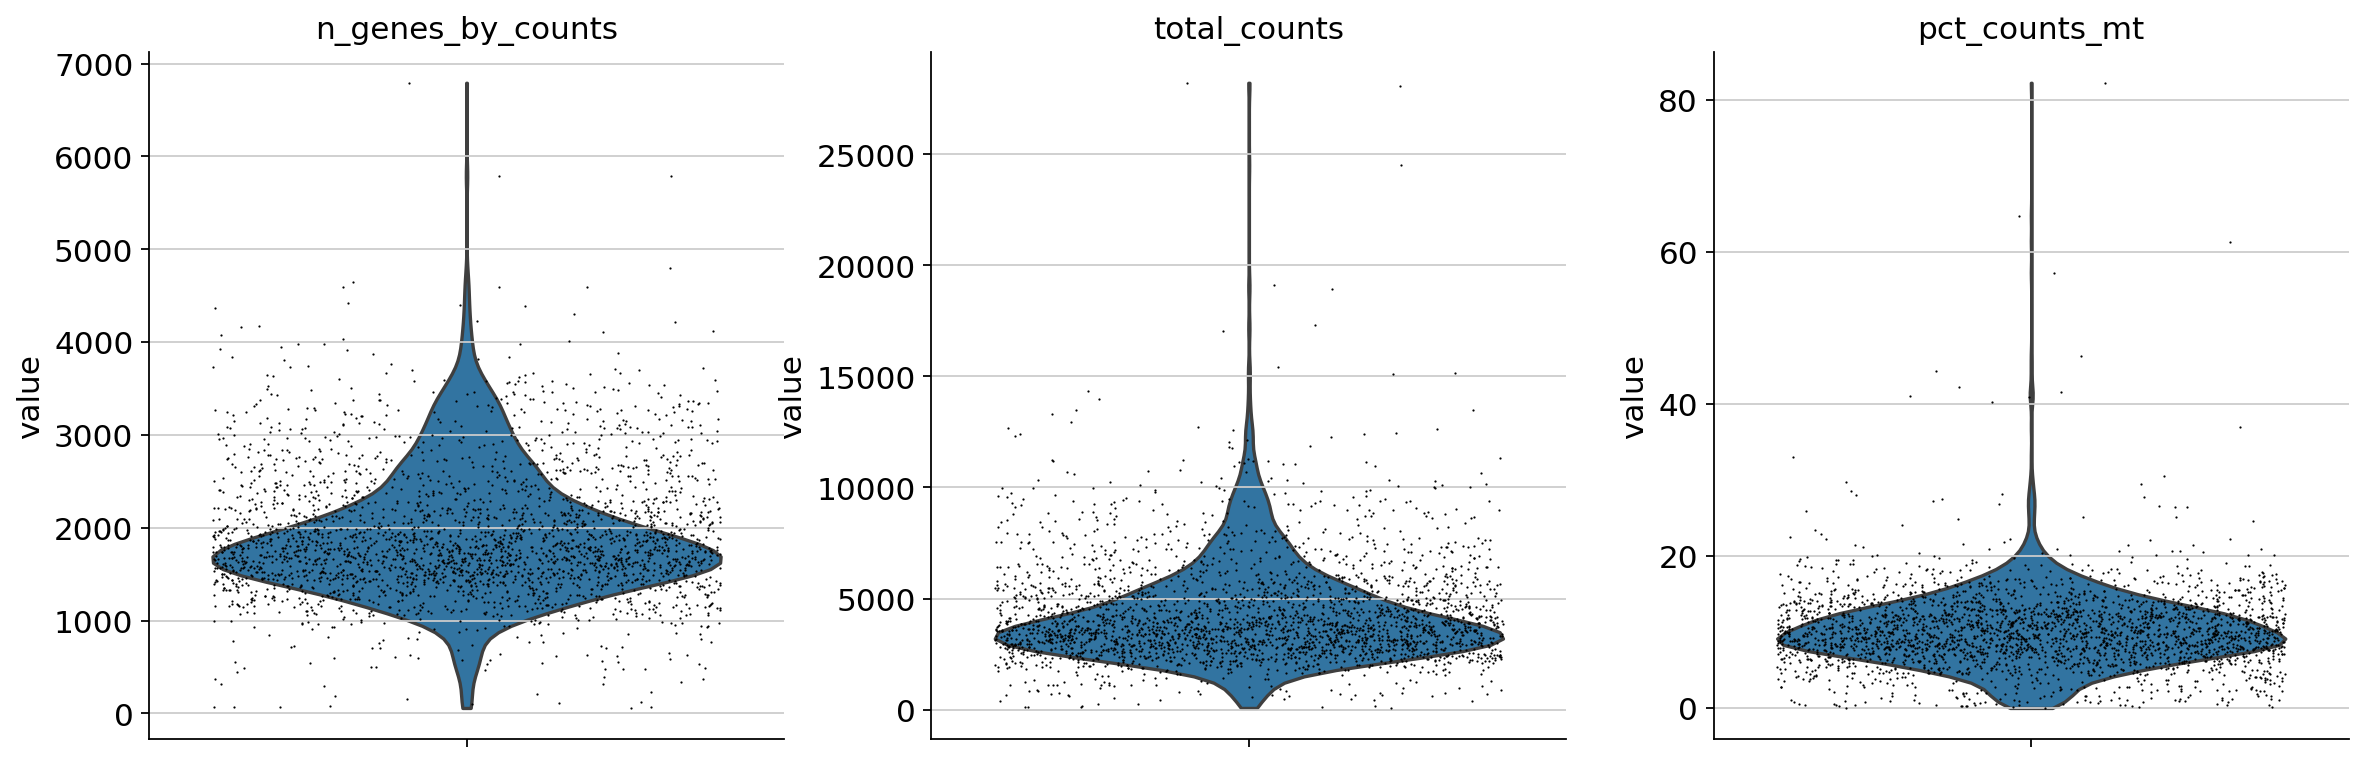

In [ ]:
sc.pl.violin(cdata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2711 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

preprocessing

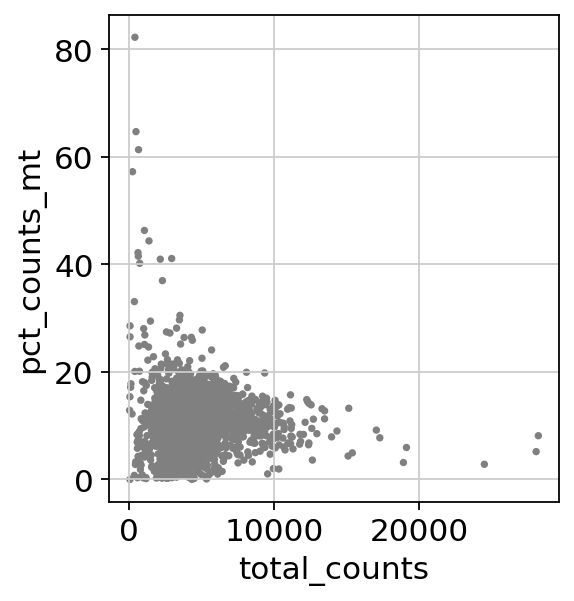

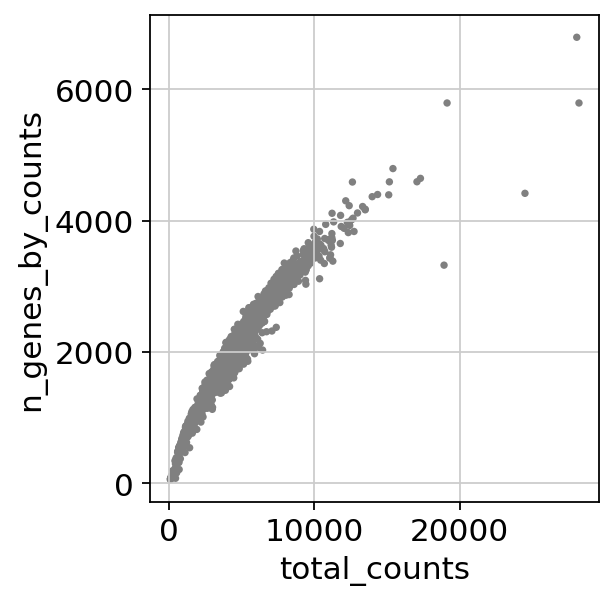

In [ ]:
sc.pl.scatter(cdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(cdata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# adata = adata[adata.obs.n_genes_by_counts < 4000, :]
# adata = adata[adata.obs.pct_counts_mt < 20, :]

In [ ]:
sc.pp.normalize_total(cdata, target_sum=1e4)

In [ ]:
sc.pp.log1p(cdata)

In [ ]:
sc.pp.highly_variable_genes(cdata, min_mean=0.0125, max_mean=3, min_disp=0.5)

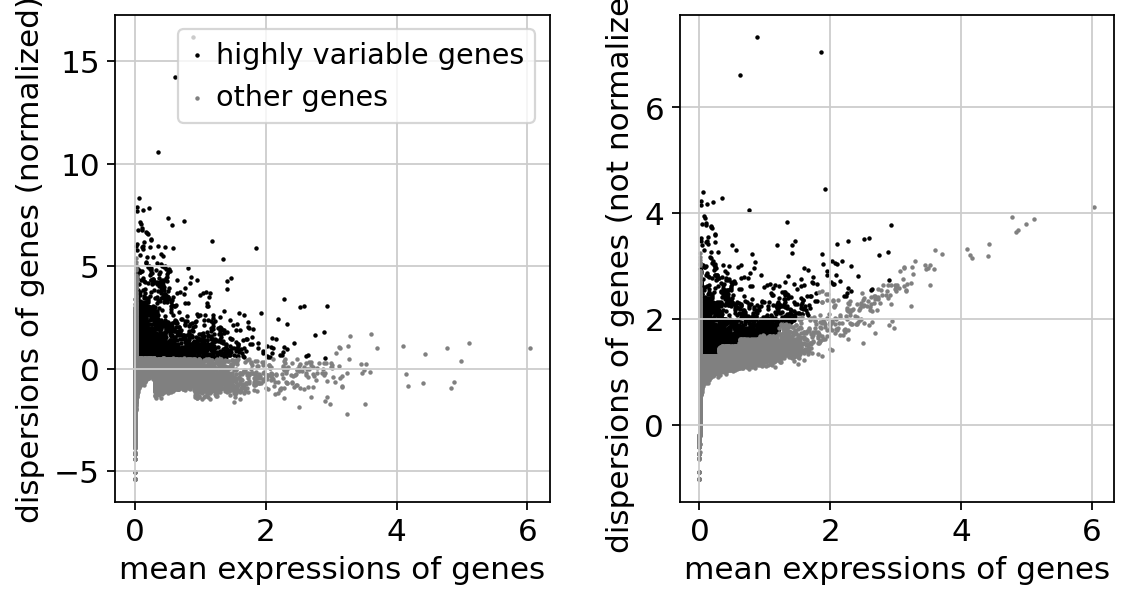

In [ ]:
sc.pl.highly_variable_genes(cdata)

In [ ]:
cdata.raw = cdata

In [ ]:
cdata = cdata[:, cdata.var.highly_variable]

In [ ]:
sc.pp.regress_out(cdata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(cdata, max_value=10)

Find marker genes

In [ ]:
latent = bas.get_latent_representation()
cdata.obsm["X_scbasset"] = latent

In [ ]:

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(cdata, use_rep="X_scbasset")
# compute the umap
sc.tl.umap(cdata)
sc.tl.leiden(cdata, key_added="leiden_scbasset")

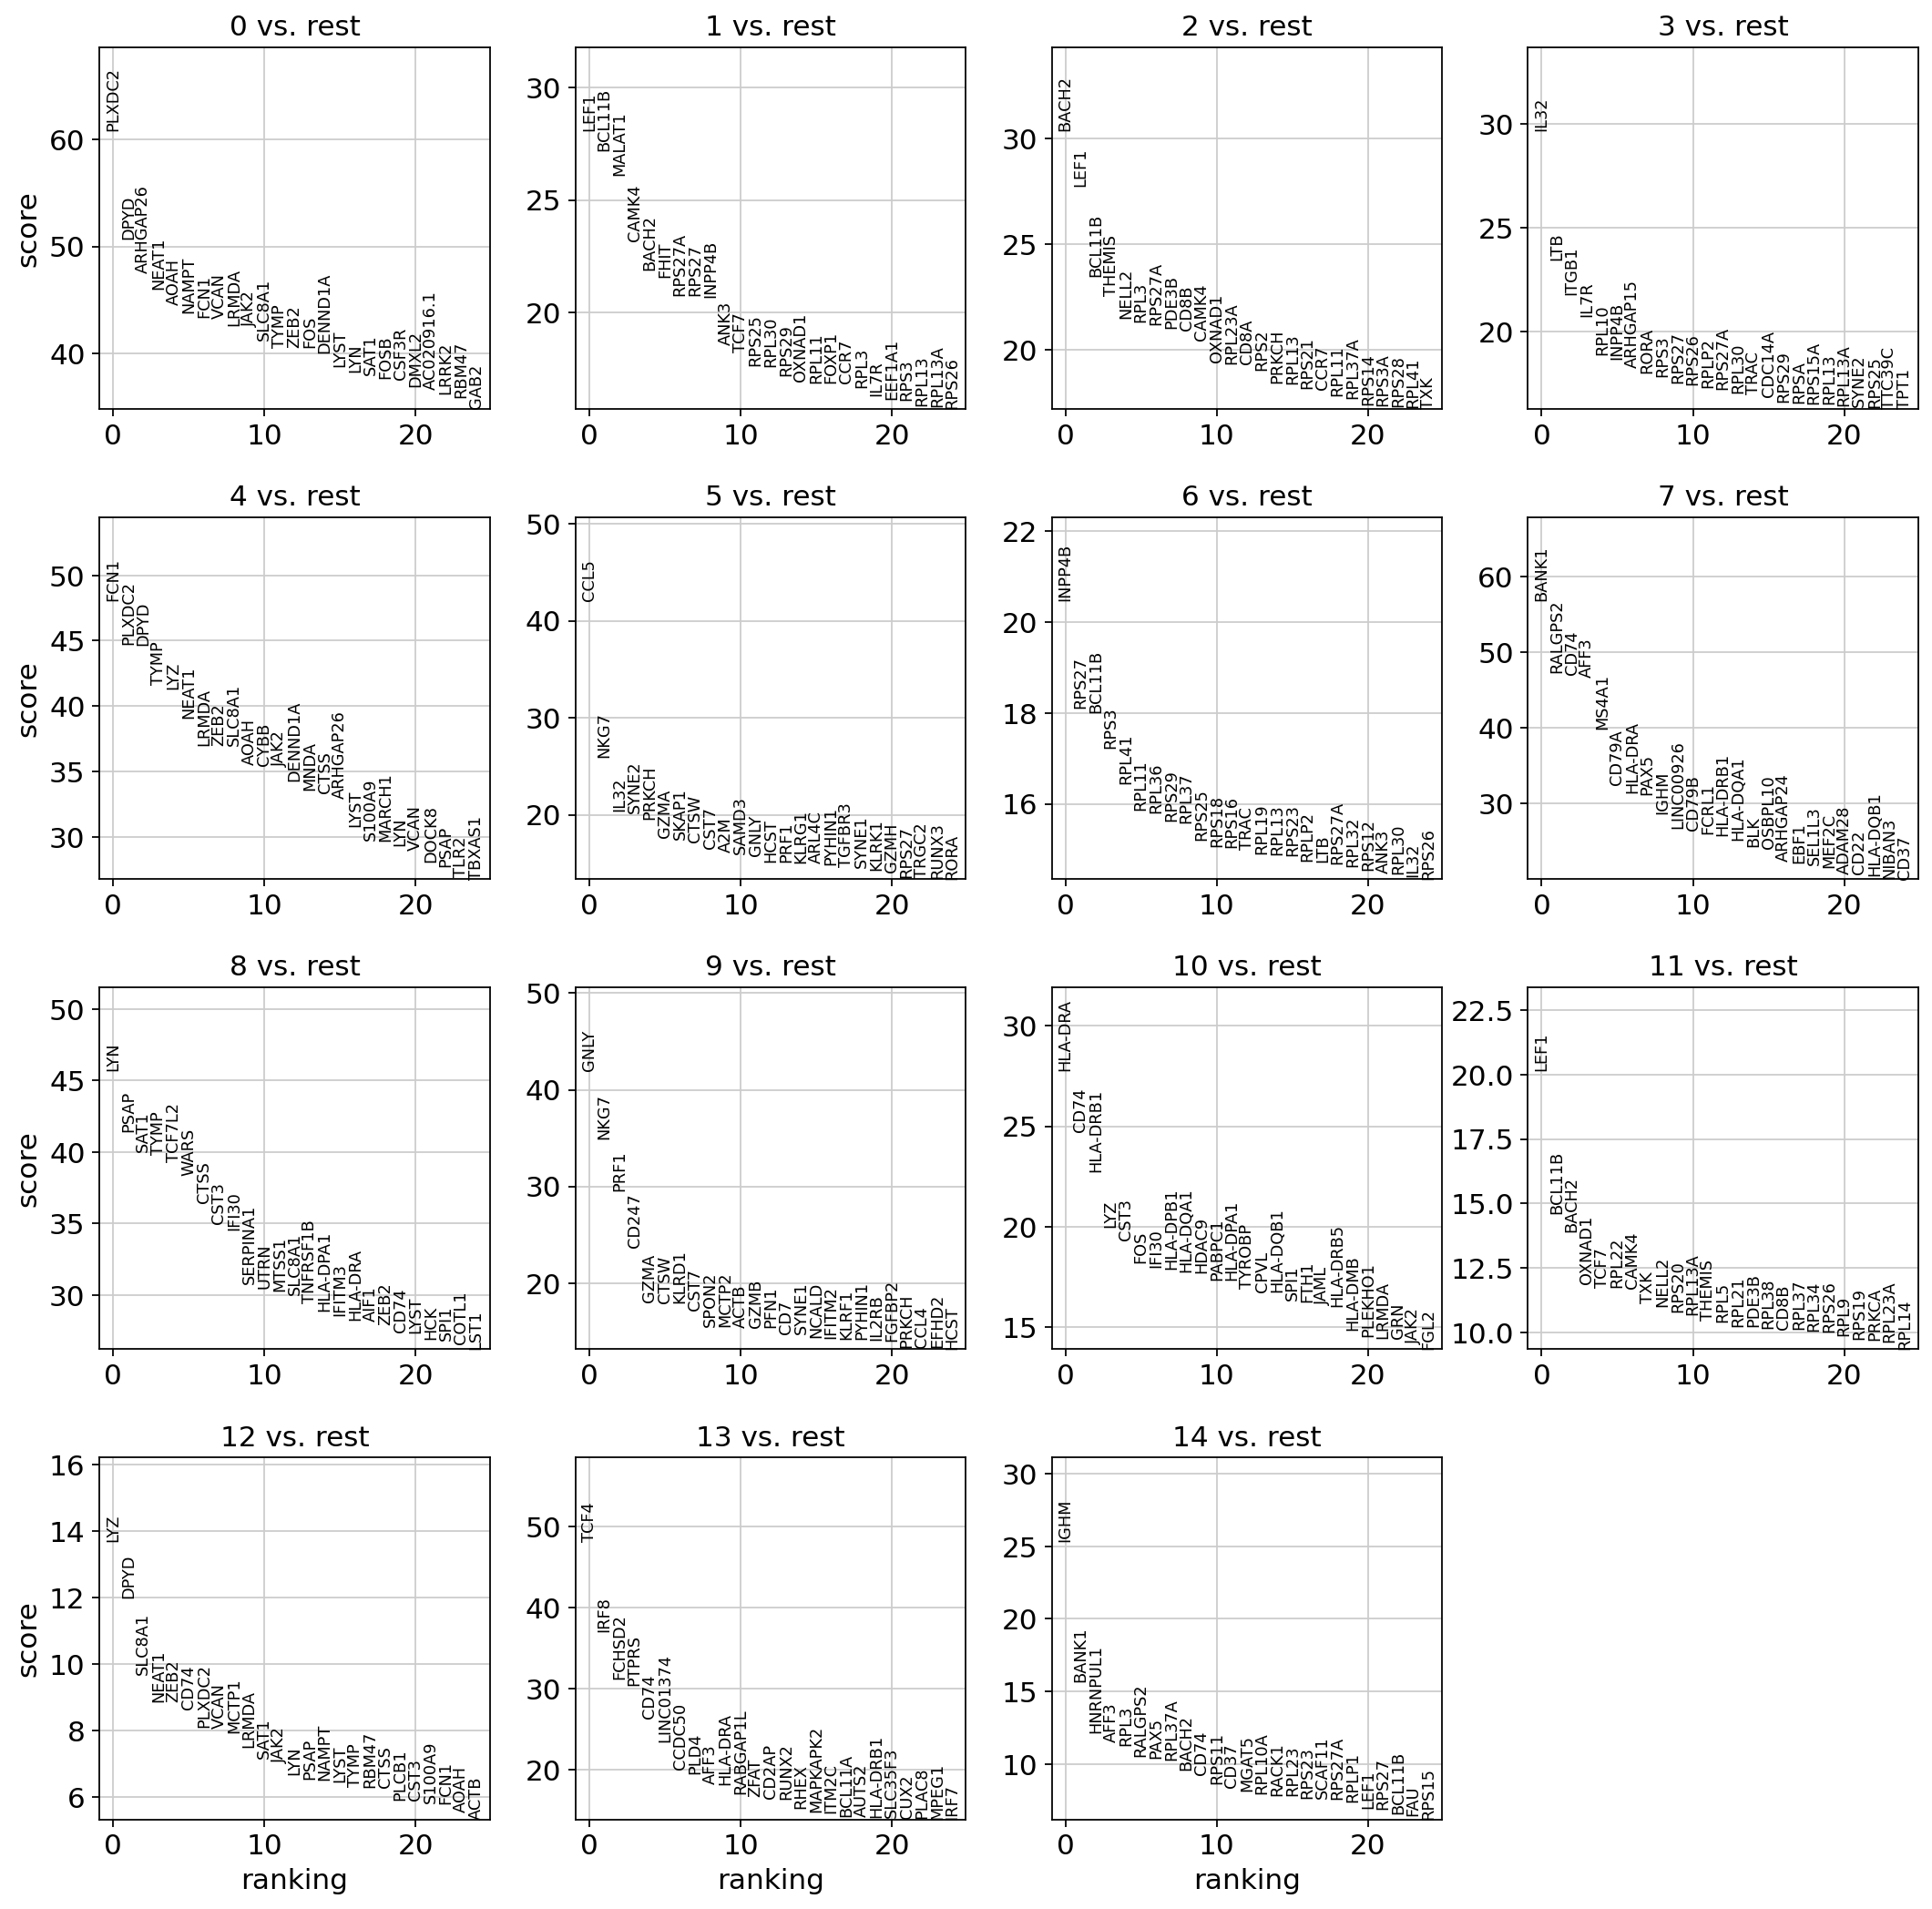

In [ ]:
sc.tl.rank_genes_groups(cdata, 'leiden_scbasset', method='t-test')
sc.pl.rank_genes_groups(cdata, n_genes=25, sharey=False)

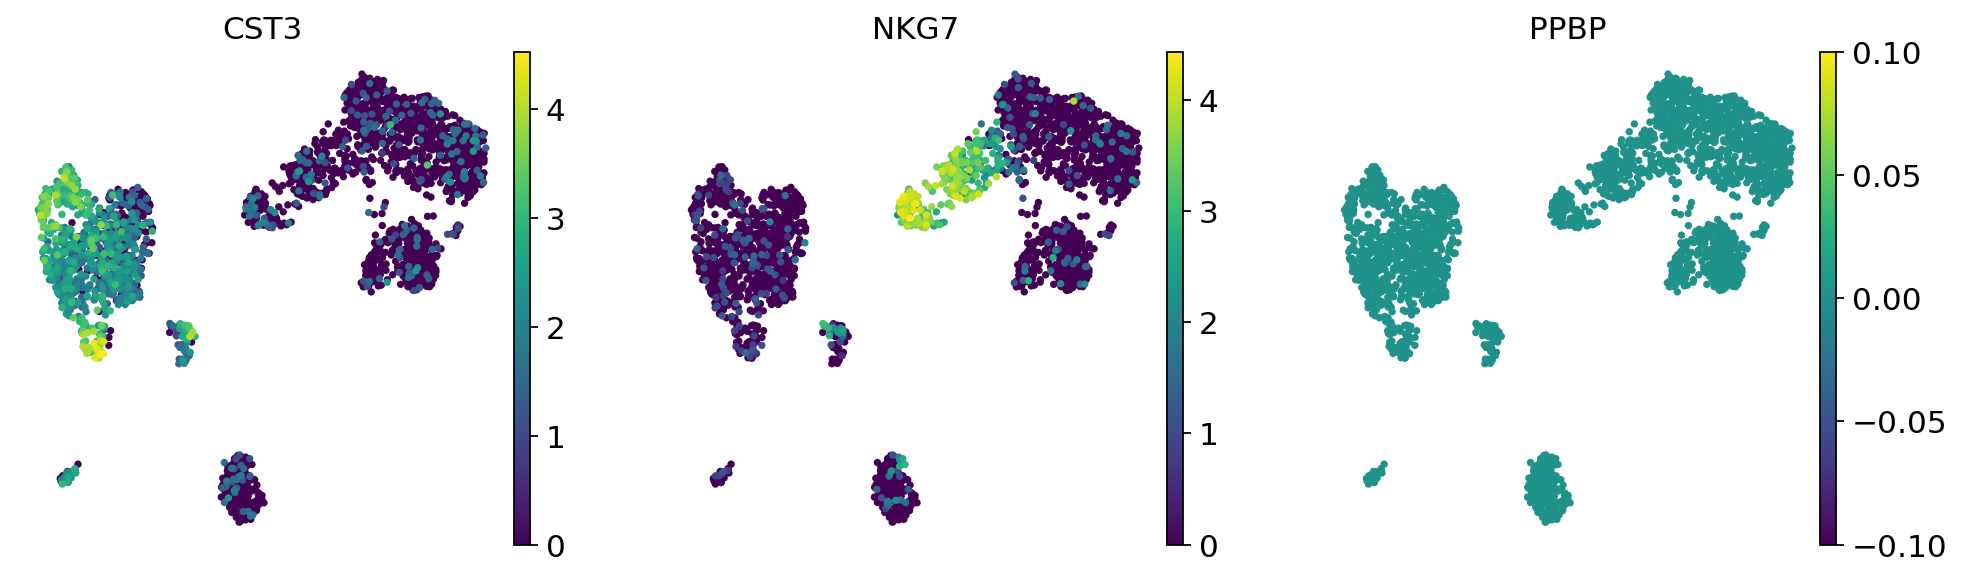

In [ ]:
sc.pl.umap(cdata, color=['CST3', 'NKG7', 'PPBP'])

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


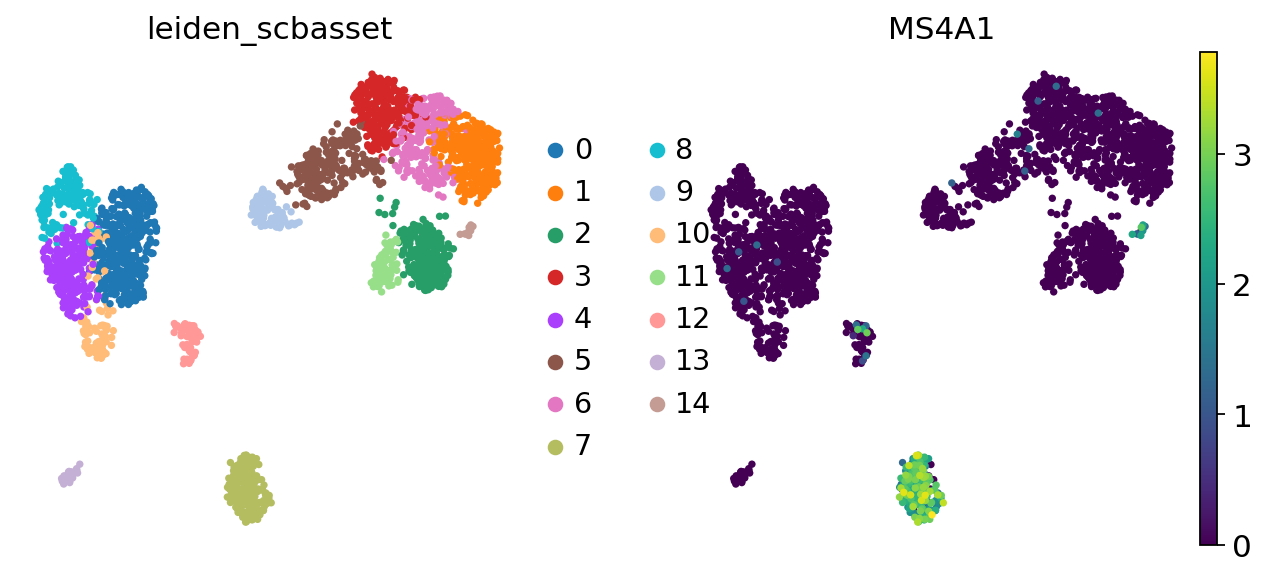

In [ ]:
sc.pl.umap(cdata, color=['leiden_scbasset', 'MS4A1'])

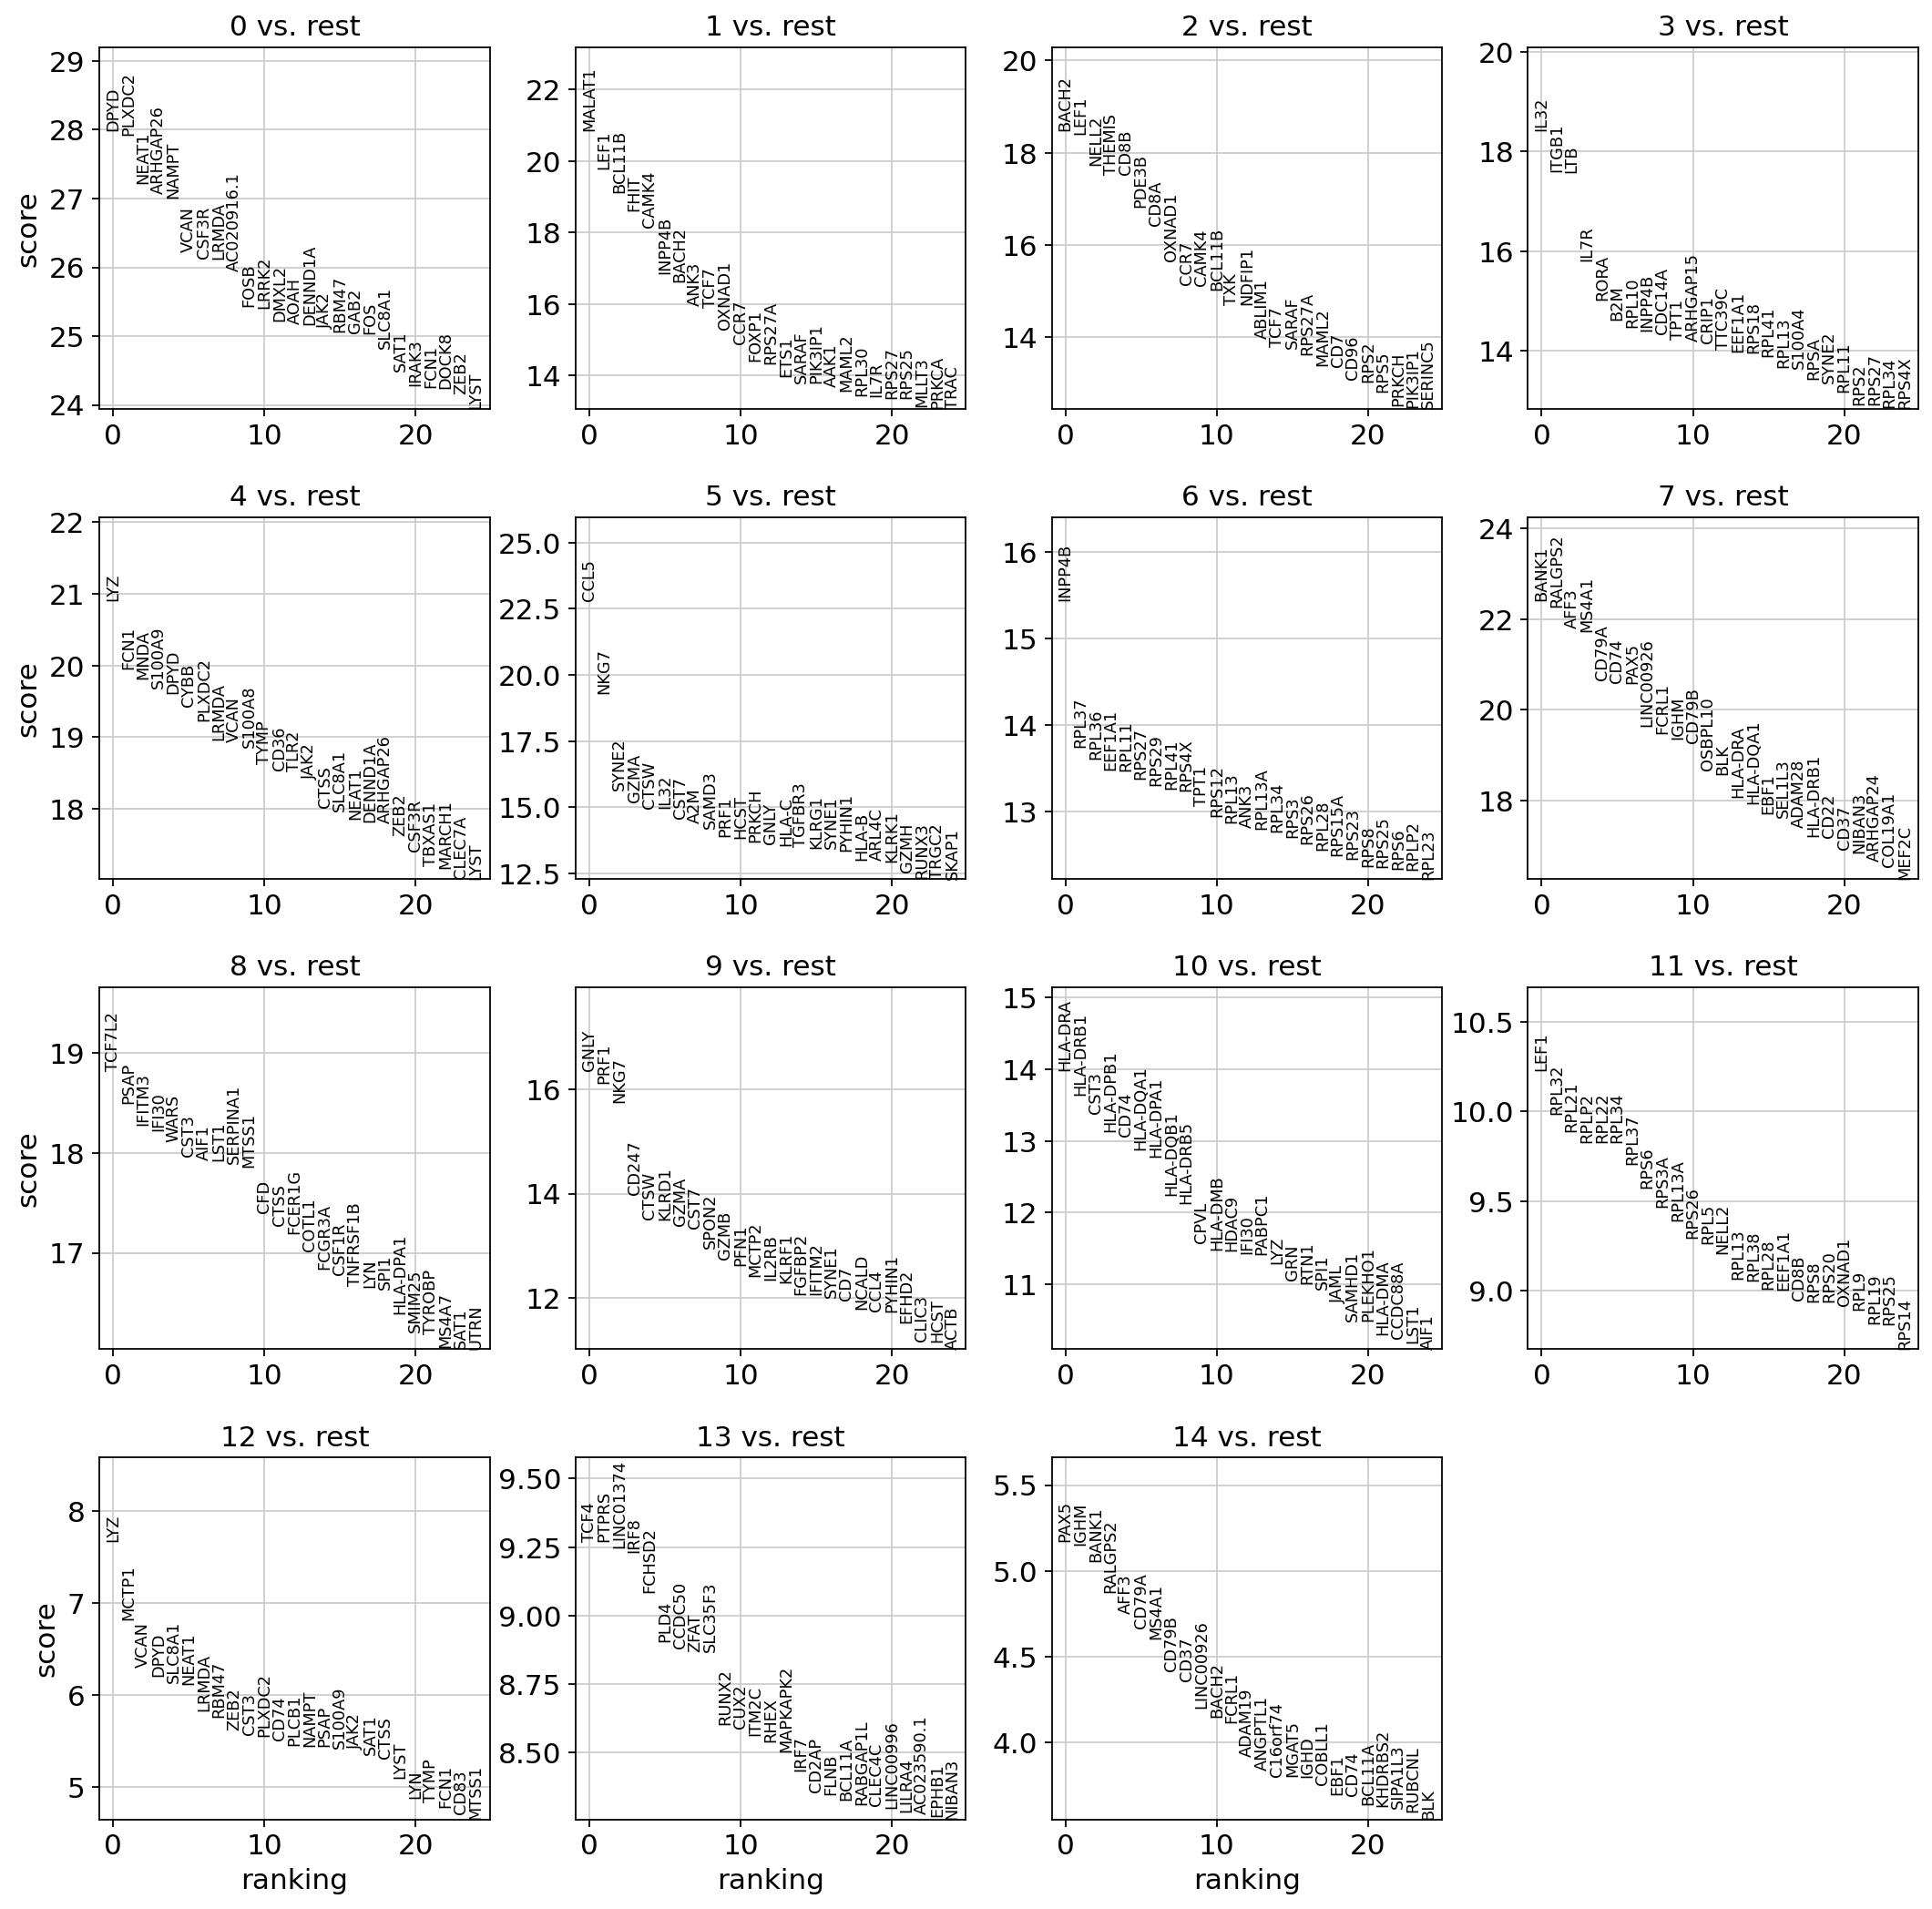

In [ ]:
sc.tl.rank_genes_groups(cdata, 'leiden_scbasset', method='wilcoxon')
sc.pl.rank_genes_groups(cdata, n_genes=25, sharey=False)

In [ ]:
import pandas as pd
pd.DataFrame(cdata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,DPYD,MALAT1,BACH2,IL32,LYZ,CCL5,INPP4B,BANK1,TCF7L2,GNLY,HLA-DRA,LEF1,LYZ,TCF4,PAX5
1,PLXDC2,LEF1,LEF1,ITGB1,FCN1,NKG7,RPL37,RALGPS2,PSAP,PRF1,HLA-DRB1,RPL32,MCTP1,PTPRS,IGHM
2,NEAT1,BCL11B,NELL2,LTB,MNDA,SYNE2,RPL36,AFF3,IFITM3,NKG7,CST3,RPL21,VCAN,LINC01374,BANK1
3,ARHGAP26,FHIT,THEMIS,IL7R,S100A9,GZMA,EEF1A1,MS4A1,IFI30,CD247,HLA-DPB1,RPLP2,DPYD,IRF8,RALGPS2
4,NAMPT,CAMK4,CD8B,RORA,DPYD,CTSW,RPL11,CD79A,WARS,CTSW,CD74,RPL22,SLC8A1,FCHSD2,AFF3




0.   unknown
1.   Naive CD4 T
2.   CD8 T
3.   Memory CD4+
4.   Unknown
5.   NK
6.   Unknown
7.   B
8.   FCGR3A Mono
9.   NK
10.   DC
11.   Unknown
12.   DC
13.   Unknown
14.   DC











In [ ]:
new_cluster_names = [
'0 unknown',
'1 Naive CD4 T',
'2 CD8 T',
'3 Memory CD4+',
'4 Unknown',
'5 NK',
'6 Unknown',
'7 B',
'8 FCGR3A Mono',
'9 NK',
'10 DC',
'11 Unknown',
'12 DC',
'13 Unknown',
'14 DC']
adata.rename_categories('leiden_scbasset', new_cluster_names)

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


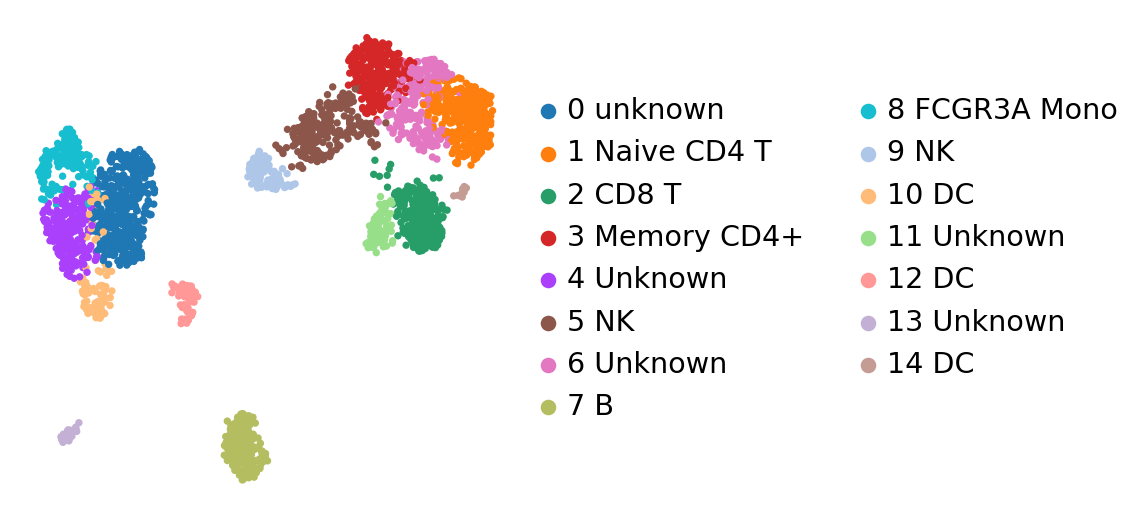

In [ ]:
sc.pl.umap(adata, color='leiden_scbasset', title='', frameon=False, save='.pdf')

## Test clustering performance

In [ ]:
with open('ddata.pickle', 'rb') as f:
    ddata = pickle.load(f)

In [ ]:
# Create a dictionary to map cluster names from scRNA-seq to scATAC-seq
cluster_map = {
    'CD4 T(0)': 'CD4 T',
    'Naive CD4 T(1)': 'Naive CD4 T',
    '2': 'unknown',
    'CD14 Monocytes(3)': 'CD14 Monocytes',
    '4': 'unknown',
    'B': 'B',
    'NK': 'NK',
    'CD14 Monocytes(7)': 'CD14 Monocytes',
    'FCGR3A+Mono or DC': 'FCGR3A+Mono',
    'NK cell': 'NK',
    'CD14 Monocytes or DC': 'DC',
    '11': 'unknown',
    'NK cell(12)': 'NK',
    '13': 'unknown',
    '14': 'unknown'
}

# Map the cluster names from scRNA-seq to scATAC-seq
adata.obs['leiden'] = ddata.obs['leiden'].map(cluster_map)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


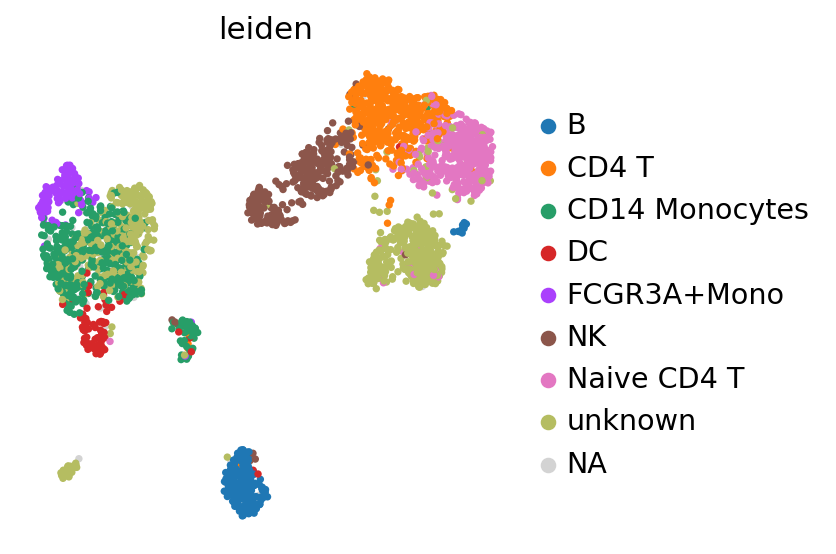

In [ ]:
sc.pl.umap(adata, color='leiden',save='scbasset')